In [34]:
# Imports
%matplotlib inline
import json
import numpy as np
from operator import itemgetter, attrgetter, methodcaller
import matplotlib.pyplot as plt

In [35]:
# Paths
base_dir = "../.."
#results_file = base_dir + "/tmp/model_4.2.4_data_test96451/predictions.json"
  #False positive count: 380, false negative count: 93, mean col density diff: -0.012891, RMSE: 0.152255, Std: 0.151708
results_file = base_dir + "/results/results_model_4.4_data_gen96629.json"
gensample_actuals = base_dir + "/data/gensample_hdf5_files/test_96629_10000.json"

In [36]:
# Read JSON files
with open(results_file,'r') as rf, open(gensample_actuals,'r') as gs:
    predictions = sorted(json.load(rf), key=itemgetter('id'))
    actuals = json.load(gs)

In [37]:
#
# Validation function that finds FP and FN in a single prediction and actual sightline.
#

EPSILON = 0.015   # Amount of error in the DLA Z value between prediction and actual, +-0.0037 ~= +-10px

def validate_sightline(prediction, actual):
    false_positives = []
    false_negatives = []
    col_density_error = []
    offset_error = []
    
    # Check each predicted DLA against all actual DLAs for false_positives and for col_density error
    for pred_dla in prediction['dlas']:
        dla_z = pred_dla['z_dla']
        matches = False
        for act_dla_ix in range(0, actual['nDLA']):
            act_dla = actual[str(act_dla_ix)]
            if abs(dla_z - act_dla['zabs']) < EPSILON:
                matches = True
                col_density_error.append((act_dla['NHI'], pred_dla['column_density'] - act_dla['NHI']))
                offset_error.append((act_dla['NHI'], abs(pred_dla['z_dla']-act_dla['zabs'])))
        if not matches:
            false_positives.append(pred_dla)
        
    # Check each actual DLA against all predicted DLAs for false_negatives
    for act_dla_ix in range(0, actual['nDLA']):
        act_dla = actual[str(act_dla_ix)]
        matches = False
        for pred_dla in prediction['dlas']:
            dla_z = pred_dla['z_dla']
            if abs(dla_z - act_dla['zabs']) < EPSILON:
                matches = True
        if not matches:
            false_negatives.append(act_dla)

    return false_positives, false_negatives, col_density_error, offset_error

# ix = 5
# validate_sightline(results[ix], gensample[str(ix)])

# Count of False Positives, False Negatives and Column Density stats

In [38]:
# List misclassified results
all_false_positives = []
all_false_negatives = []
all_coldensity_diff = []
all_offset_error = []

for i in range(0,10000):
    fp, fn, cd, oe = validate_sightline(predictions[i], actuals[str(i)])
    all_offset_error.extend(oe)
    for f in fp:
        f['id'] = predictions[i]['id']
        f['z_qso'] = predictions[i]['z_qso']
    for f in fn:
        f['id'] = i
        f['sl'] = actuals[str(i)]['sl']
    all_false_positives.extend(fp)
    all_false_negatives.extend(fn)
    all_coldensity_diff.extend(cd)

all_coldensity_matrix = np.vstack(all_coldensity_diff)
mean_col_density = np.mean(all_coldensity_matrix[:,1])
rmse_col_density = np.sqrt(np.mean(np.array(all_coldensity_matrix[:,1])**2))
std_col_density = np.std(all_coldensity_matrix[:,1])

print "False positive count: %d, false negative count: %d, mean col density diff: %02f, RMSE: %02f, Std: %02f\n" %\
    (len(all_false_positives), len(all_false_negatives),\
     mean_col_density, rmse_col_density, std_col_density)

False positive count: 532, false negative count: 163, mean col density diff: -0.006092, RMSE: 0.143246, Std: 0.143116



# Plot column density error for all matching DLAs

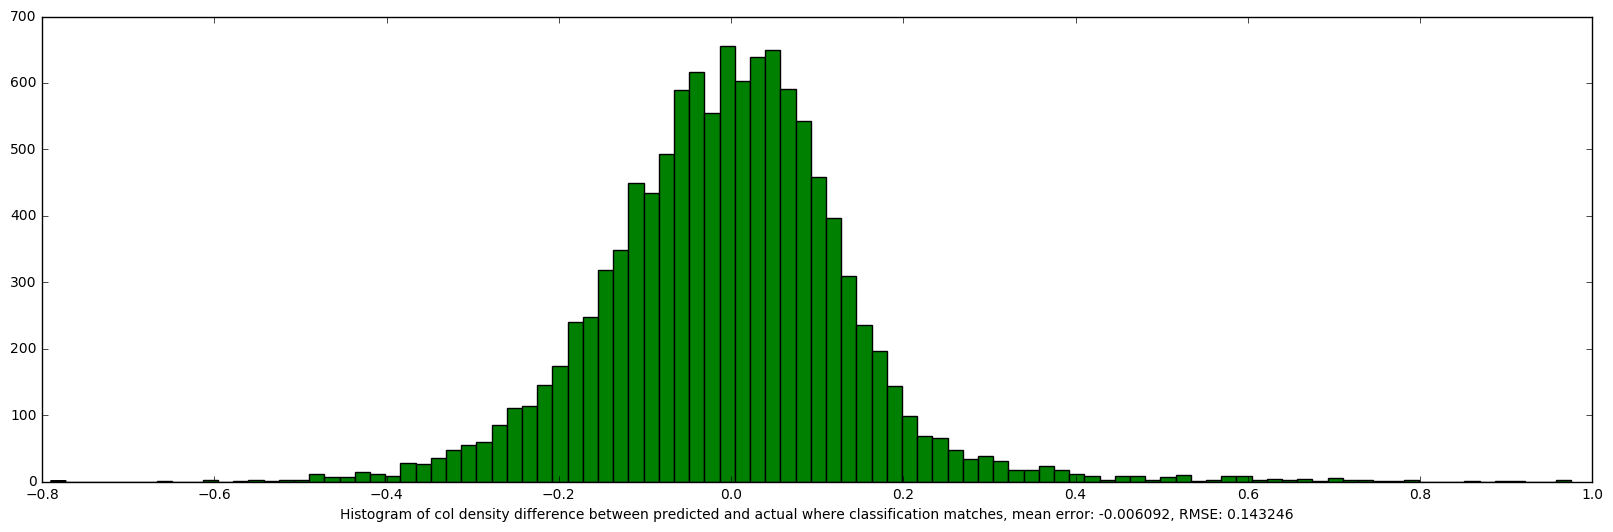

In [39]:
plt.figure(figsize=(20, 6))
plt.hist(all_coldensity_matrix[:,1], 100, facecolor='green');
plt.xlabel("Histogram of col density difference between predicted and actual where classification matches, " + \
           "mean error: %06f, RMSE: %06f" % (mean_col_density, rmse_col_density))

# Plot column density error for a range column densities

(1783, 2) 0.118777776914 0.0903982576176
(1645, 2) 0.0647430677962 0.100498021684
(1501, 2) 0.0214625840691 0.121322033027
(1280, 2) -0.0214864327857 0.120814982719
(1013, 2) -0.0411930034492 0.129496476114
(942, 2) -0.060658514119 0.131823188916
(1896, 2) -0.0814357928484 0.136335875645
(845, 2) -0.10795547094 0.138915615529
(277, 2) -0.139627190035 0.123323307707
(59, 2) -0.140800983363 0.187301816033


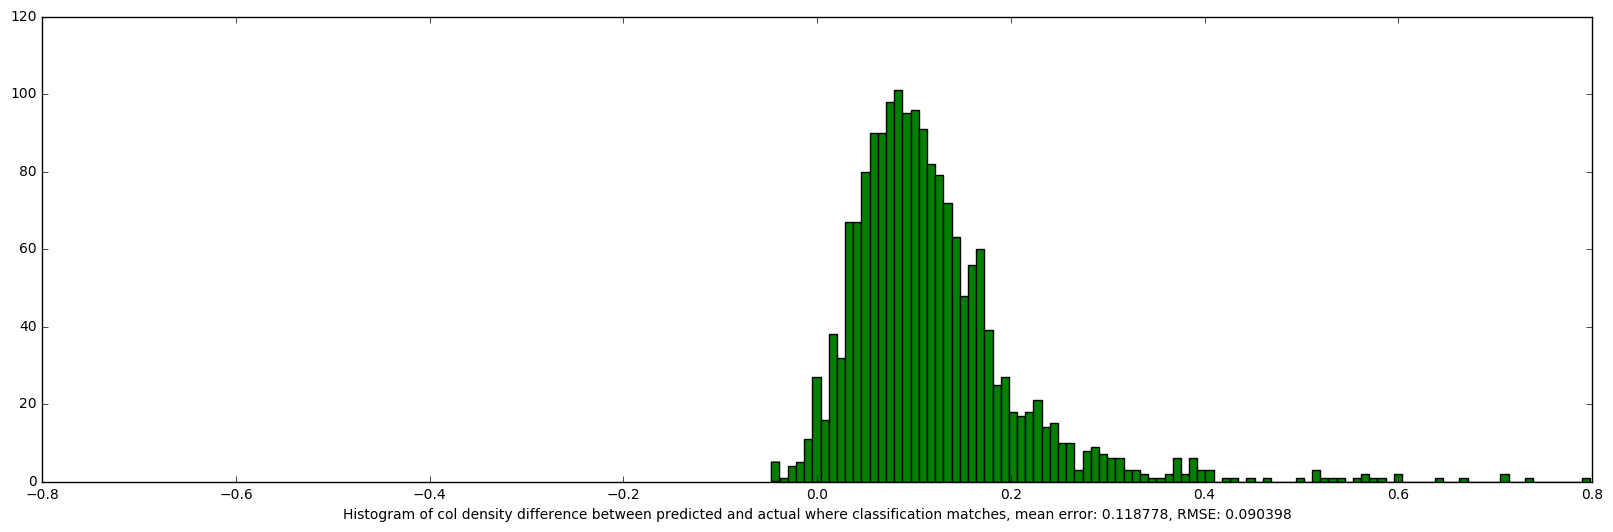

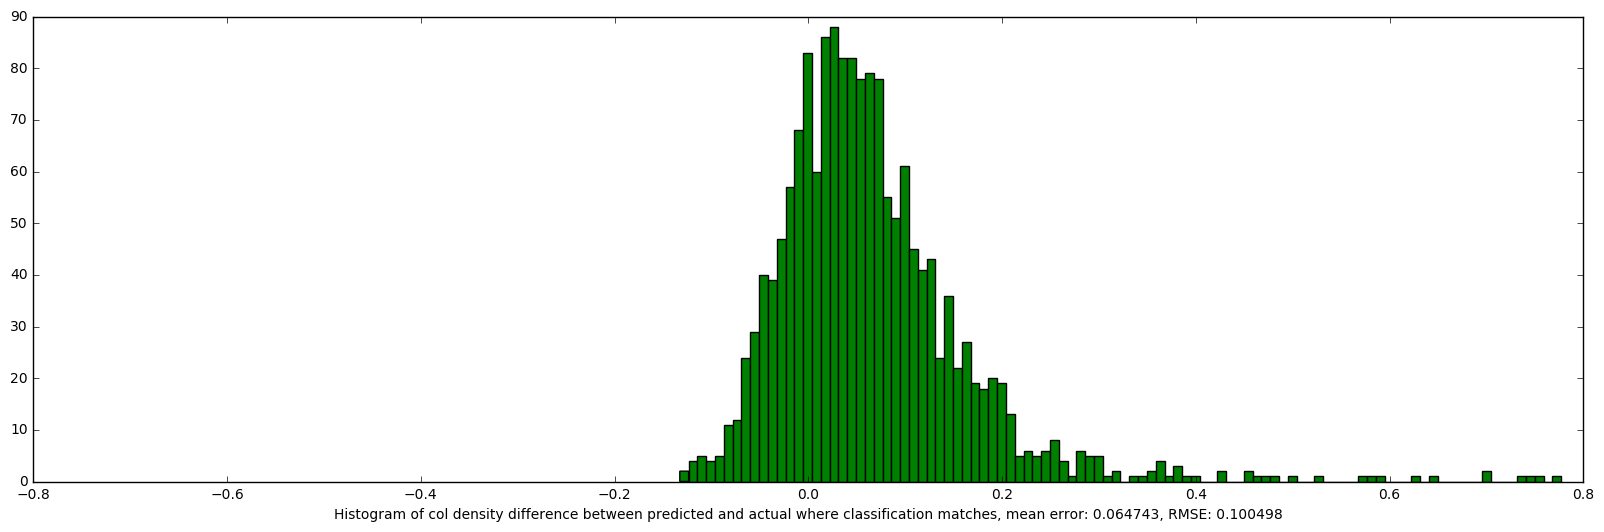

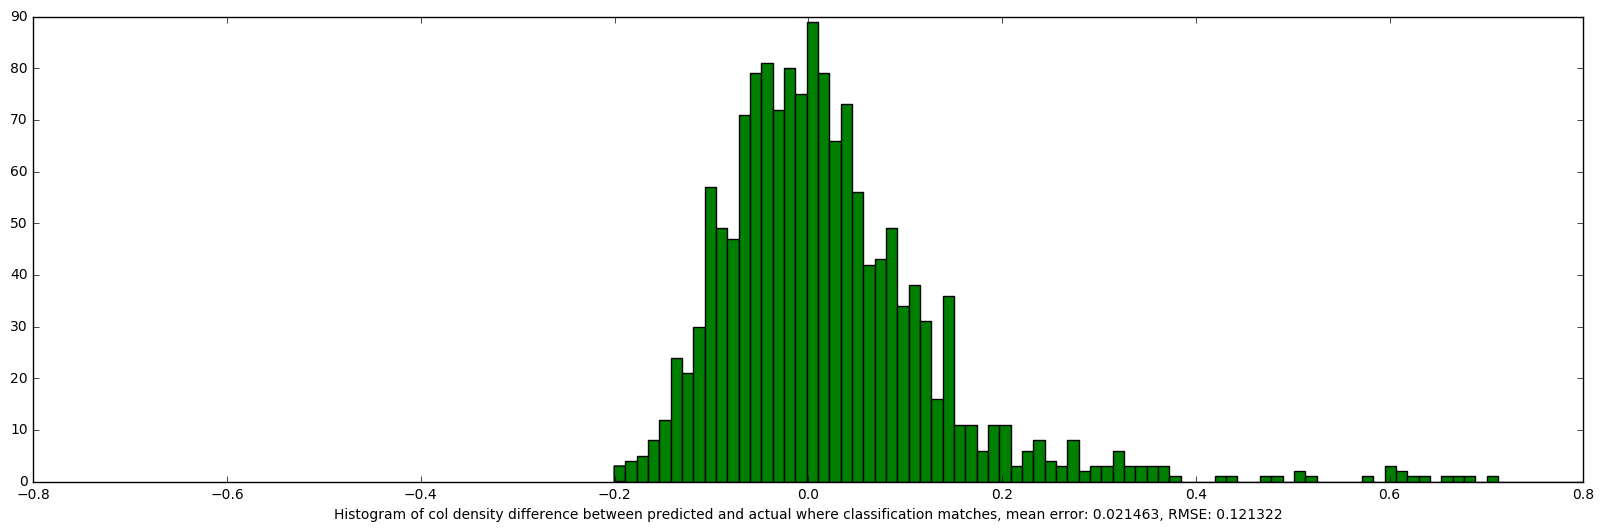

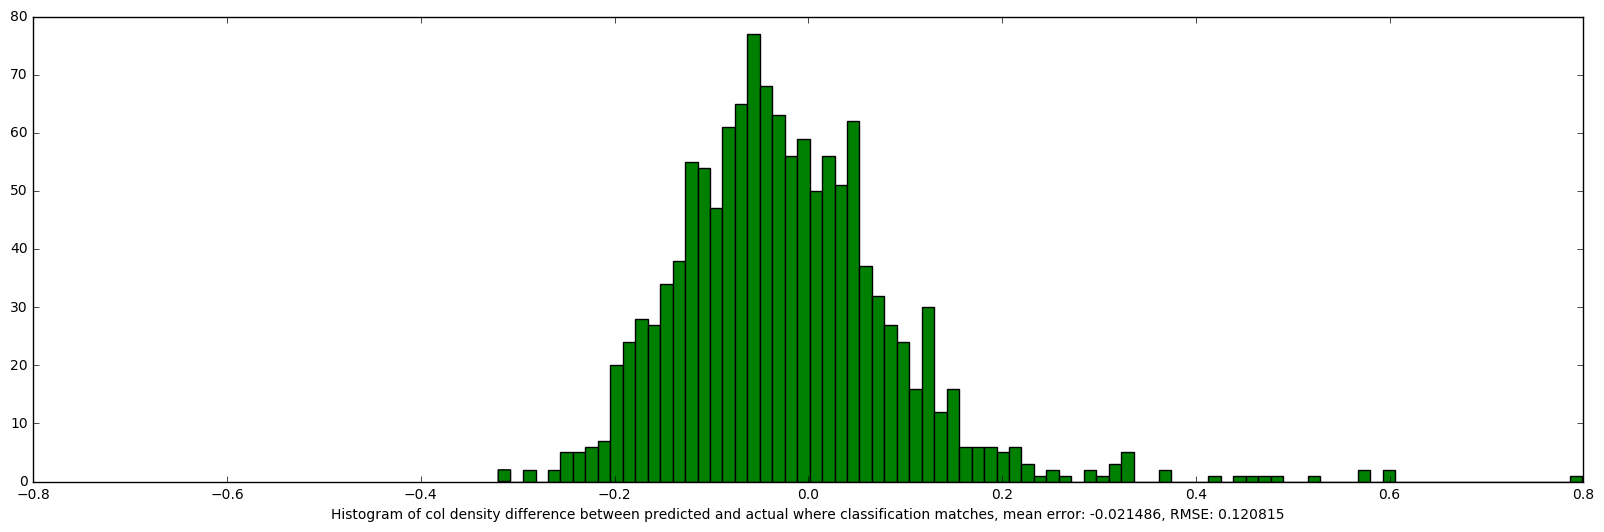

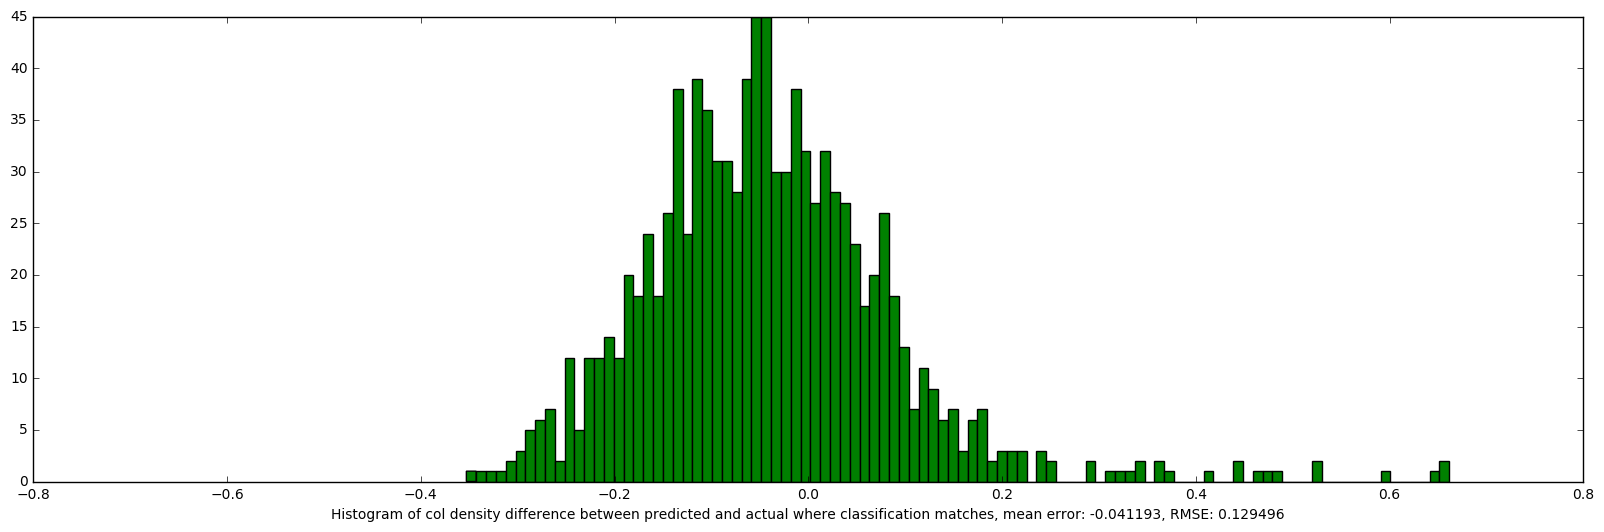

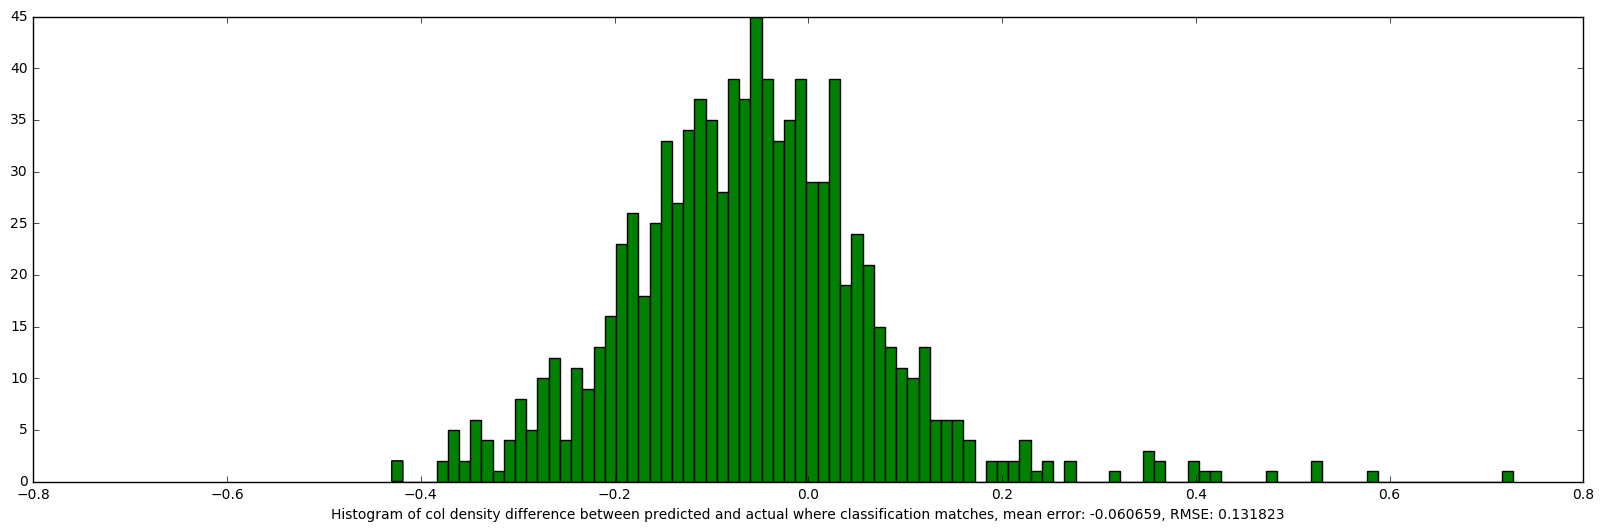

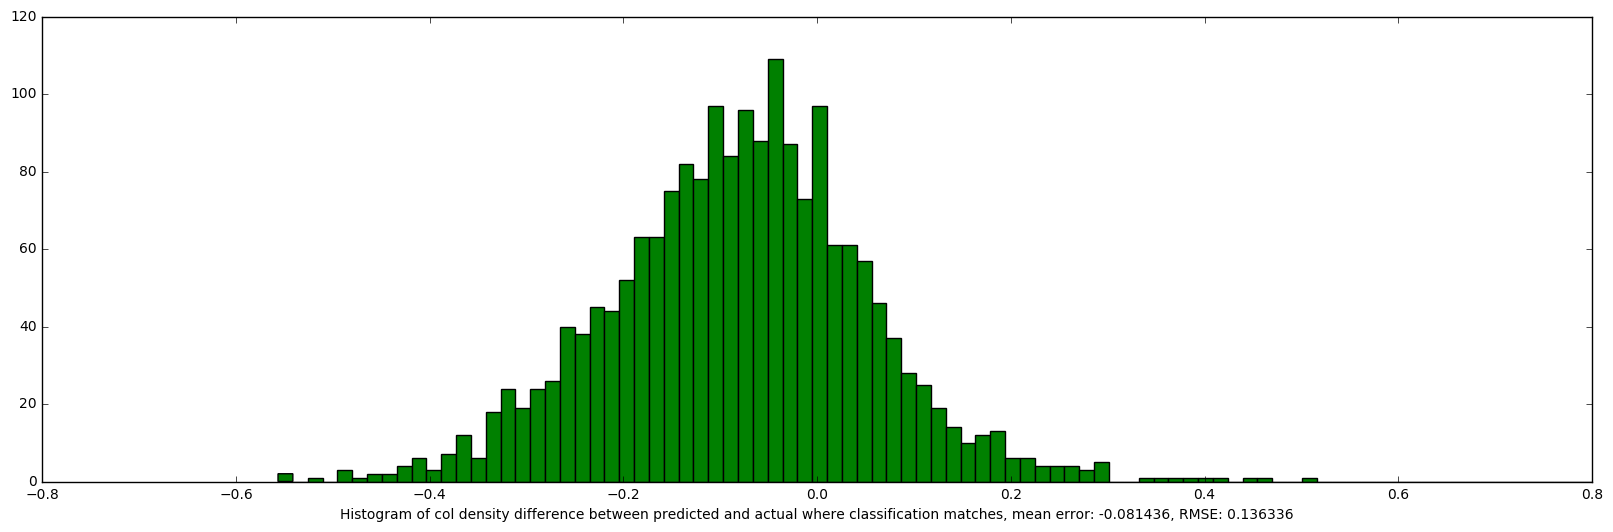

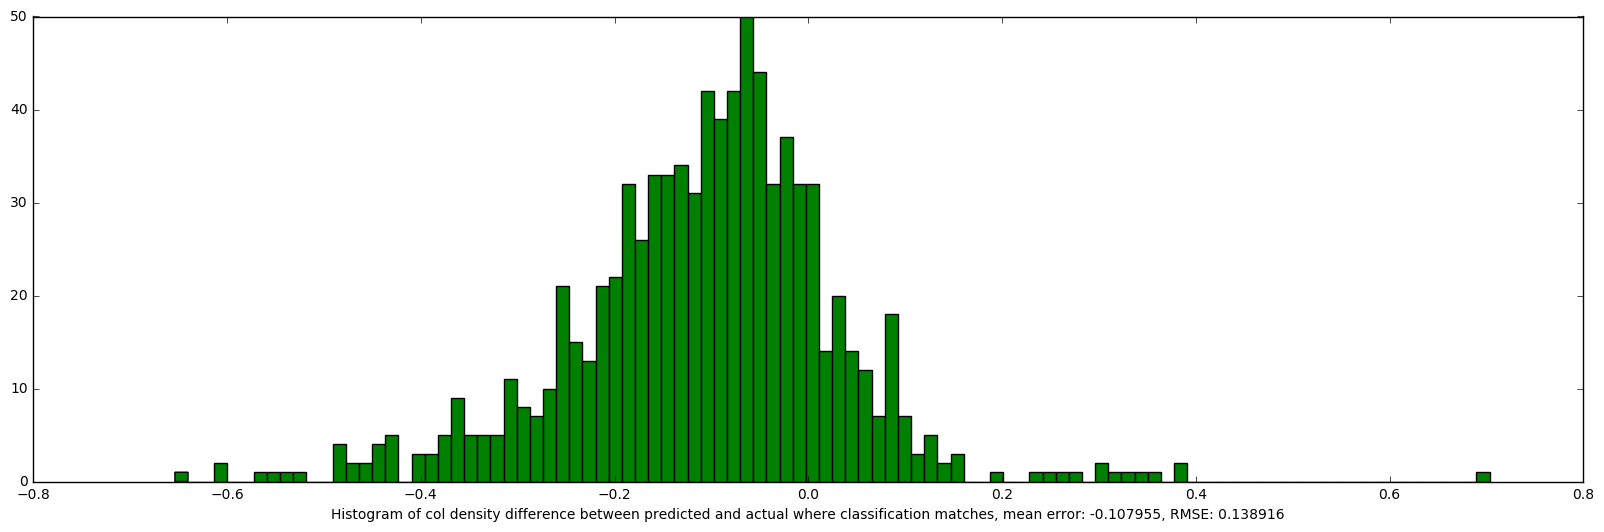

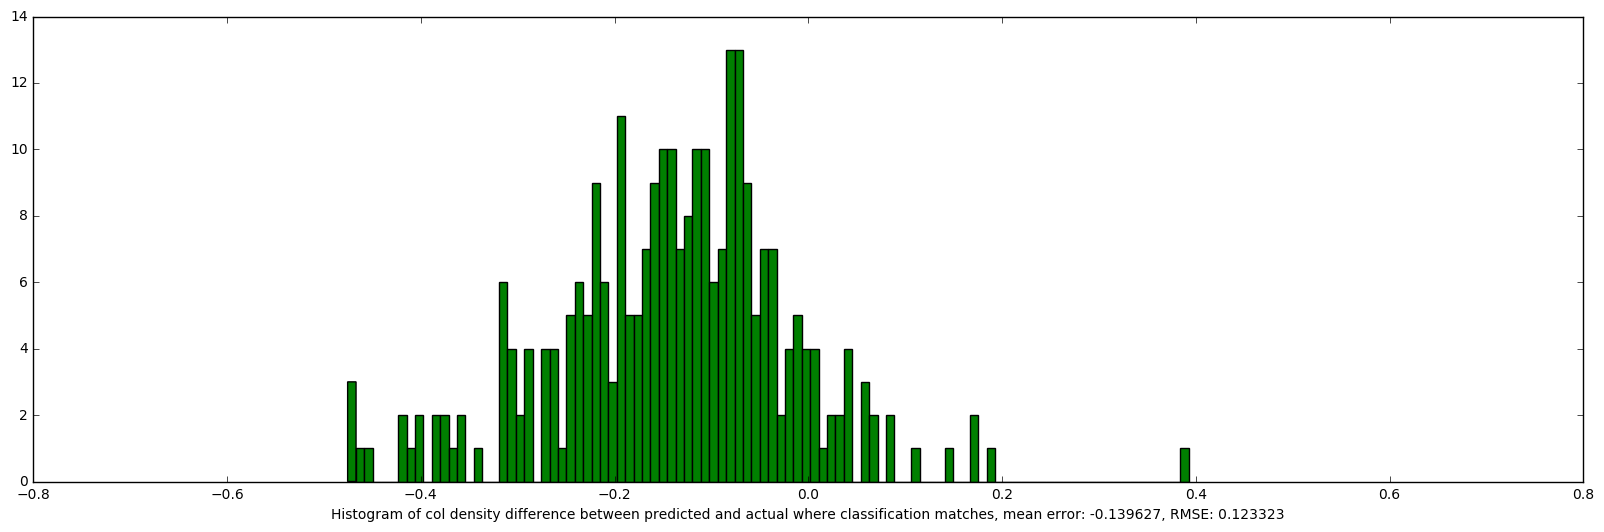

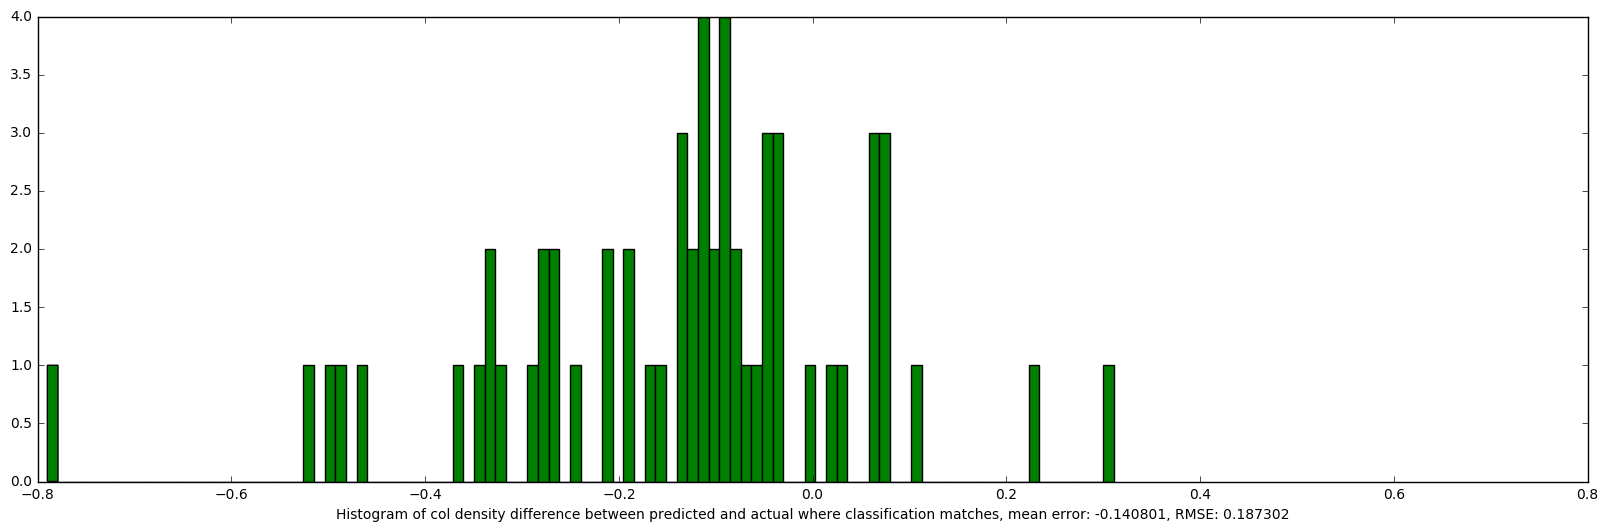

In [88]:
for range in [[20.3,20.4],
              [20.4,20.5],
              [20.5,20.6],
              [20.6,20.7],
              [20.7,20.8],
              [20.8,20.9],
              [20.9,21.2],
              [21.2,21.5],
              [21.5,21.8],
              [21.8,22.4]]:
    inrange_coldensity_matrix = all_coldensity_matrix[(all_coldensity_matrix[:,0]>=range[0])& \
                                                      (all_coldensity_matrix[:,0]<range[1])]
    plt.figure(figsize=(20, 6))
    plt.hist(inrange_coldensity_matrix[:,1], 100, facecolor='green');
    plt.xlabel("Histogram of col density difference between predicted and actual where classification matches, " + \
               "mean error: %06f, RMSE: %06f" % \
               (np.mean(inrange_coldensity_matrix[:,1]), np.std(inrange_coldensity_matrix[:,1])))
    plt.xlim([-0.8,0.8])
    print inrange_coldensity_matrix.shape, \
            np.mean(inrange_coldensity_matrix[:,1]), \
            np.std(inrange_coldensity_matrix[:,1])

# Plot dz vs column density actual (all matching samples)

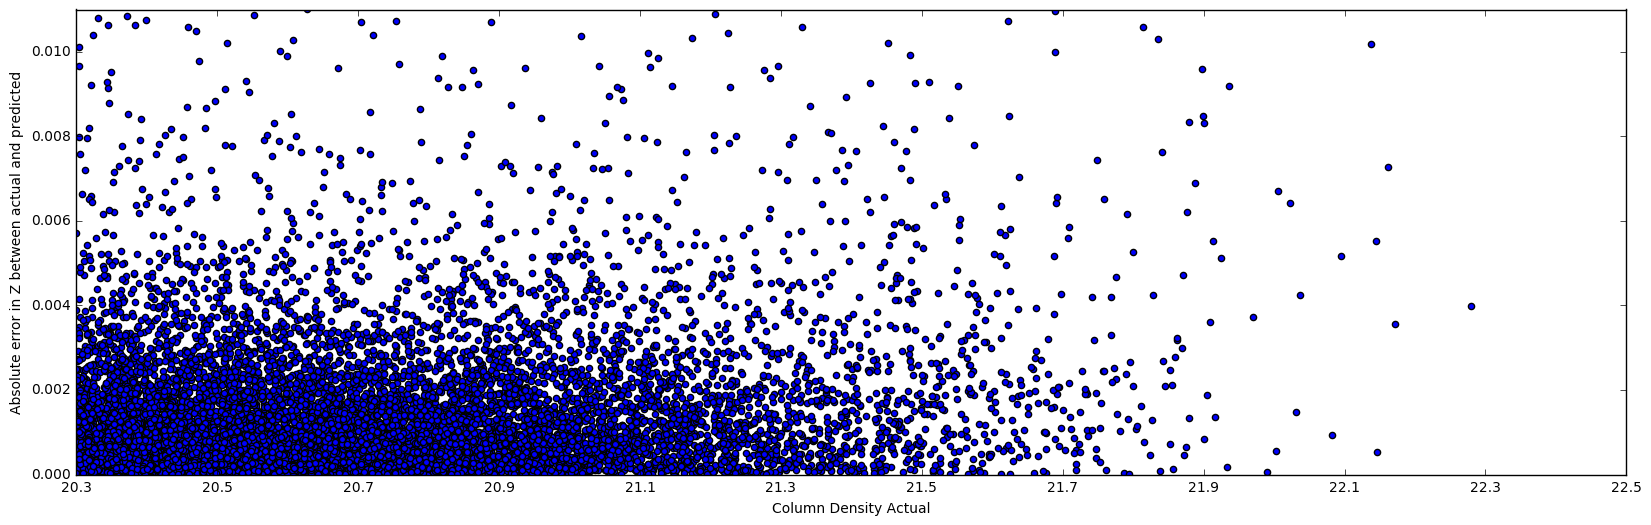

In [40]:
p = np.vstack(all_offset_error)
plt.figure(figsize=(20, 6))
plt.scatter(p[:,0], p[:,1])
plt.xlim([20.3,22.5])
plt.ylim([0,0.011])
plt.xticks([20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5])
plt.xlabel("Column Density Actual")
plt.ylabel("Absolute error in Z between actual and predicted")

# Plot column density error vs actual column density (all matching samples)

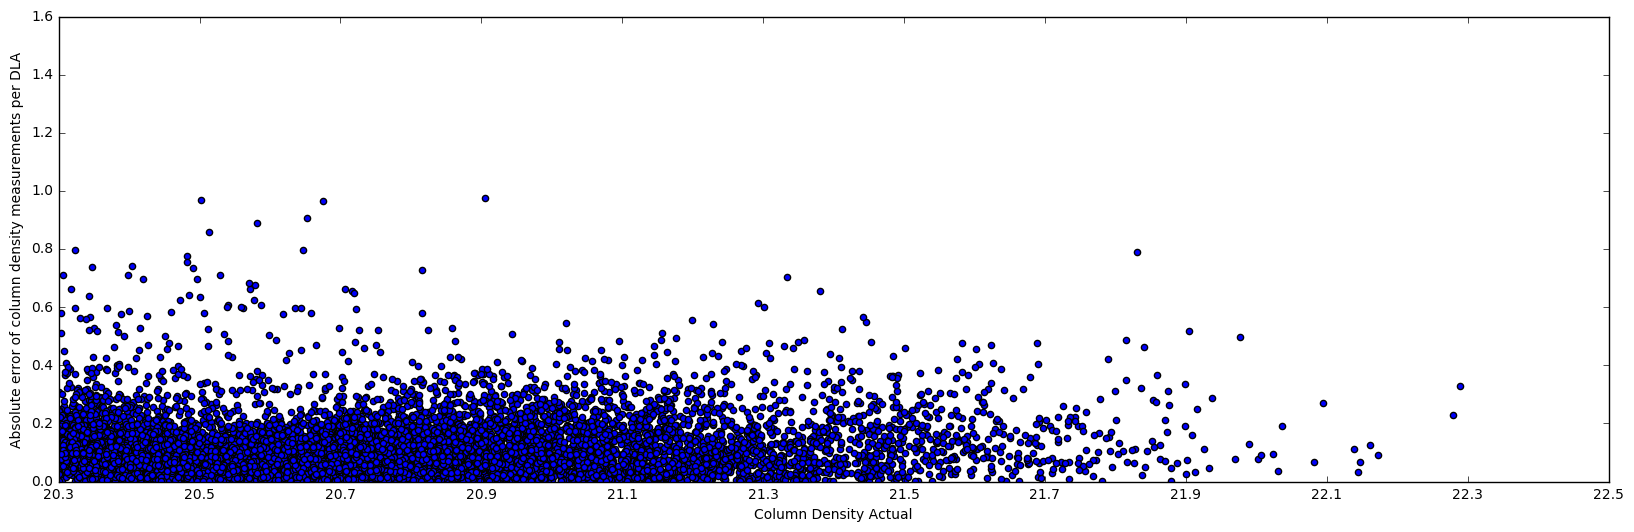

In [41]:
plt.figure(figsize=(20, 6))
plt.scatter(all_coldensity_matrix[:,0], np.abs(all_coldensity_matrix[:,1]))
plt.xlim([20.3,22.5])
plt.ylim([0,1.6])
plt.xticks([20.3,20.5,20.7,20.9,21.1,21.3,21.5,21.7,21.9,22.1,22.3,22.5])
plt.xlabel("Column Density Actual")
plt.ylabel("Absolute error of column density measurements per DLA")

# Histogram of where False Positives are found on the spectrum

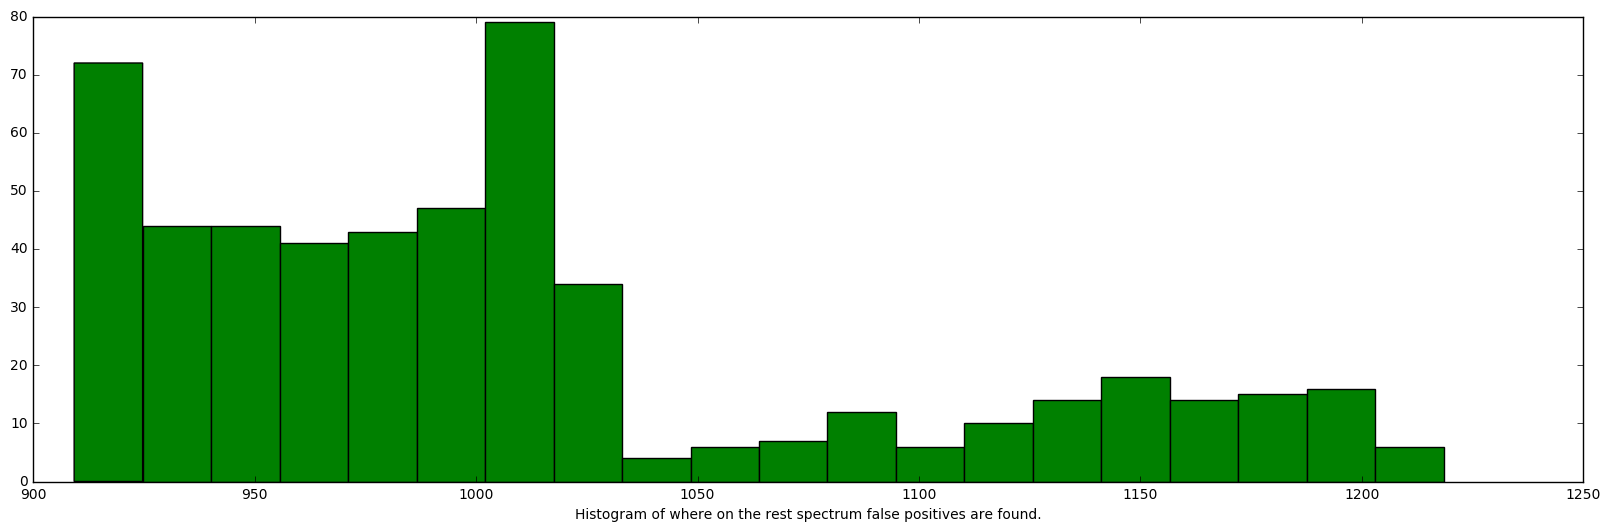

In [42]:
rest_frame_fps = [fp['rest'] for fp in all_false_positives]
plt.figure(figsize=(20, 6))
plt.hist(rest_frame_fps, 20, facecolor='green');
plt.xlabel("Histogram of where on the rest spectrum false positives are found.")

# Scatter plot of where False Positives are found on the spectrum

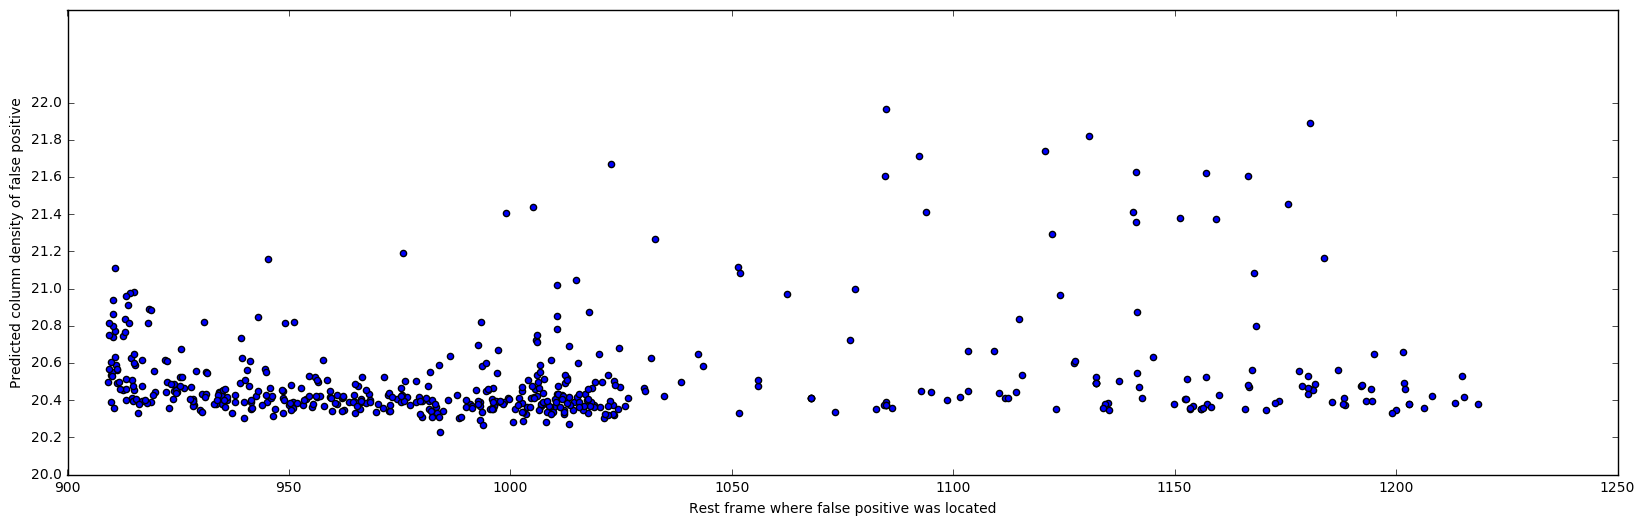

In [43]:
rest_frame_fps = [fp['rest'] for fp in all_false_positives]
col_density_fps = [fp['column_density'] for fp in all_false_positives]

plt.figure(figsize=(20, 6))
plt.scatter(rest_frame_fps, col_density_fps)
plt.xlim([900,1250])
plt.yticks([20.0,20.2,20.4,20.6,20.8,21.0,21.2,21.4,21.6,21.8,22.0])
plt.xlabel("Rest frame where false positive was located")
plt.ylabel("Predicted column density of false positive")

# False positives histogram by column density

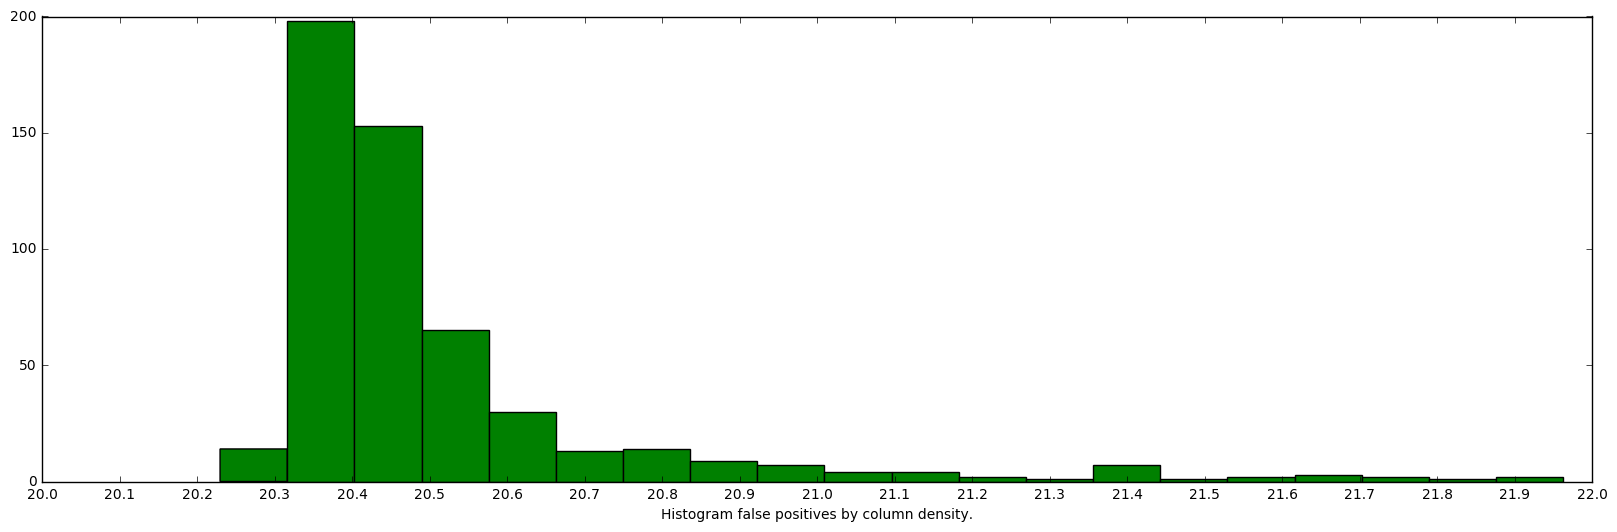

In [44]:
col_density_fps = [fp['column_density'] for fp in all_false_positives]
plt.figure(figsize=(20, 6))
plt.hist(col_density_fps, 20, facecolor='green');
plt.xlabel("Histogram false positives by column density.")
plt.xticks([20.0,20.1,20.2,20.3,20.4,20.5,20.6,20.7,20.8,20.9,21.0,21.1,21.2,21.3,21.4,21.5,21.6,21.7,21.8,21.9,22.0]);

# Confidence for False Positives vs confidence of correct DLAs

(0, 80)

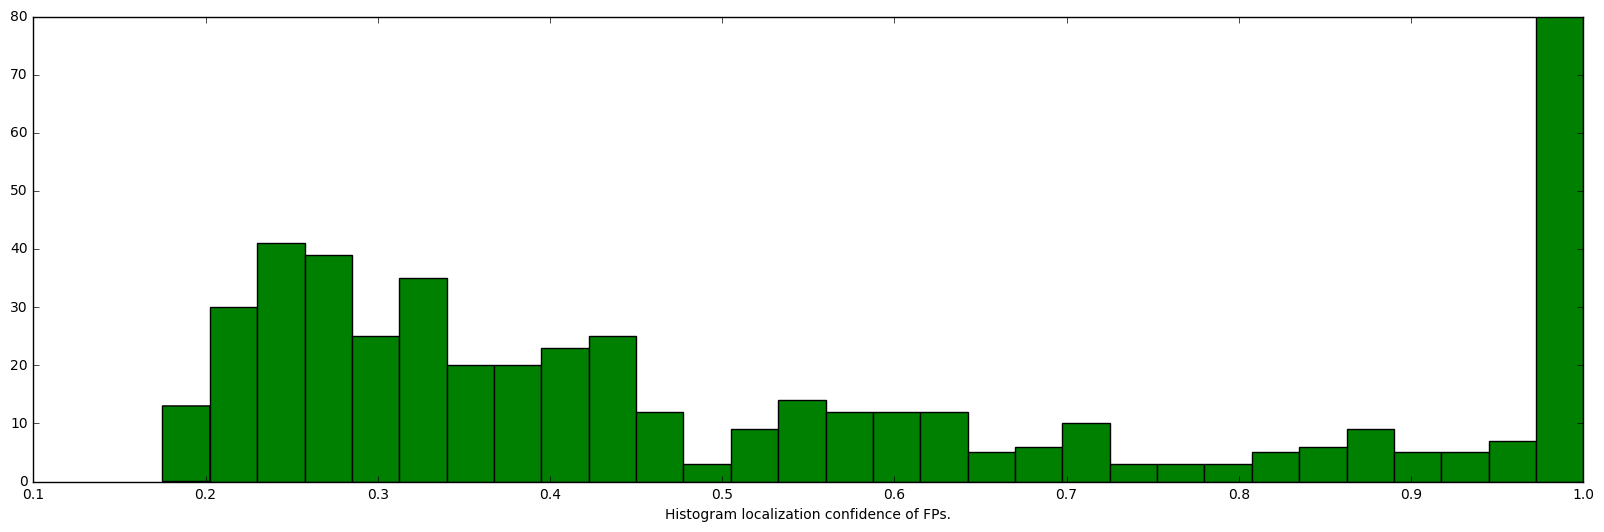

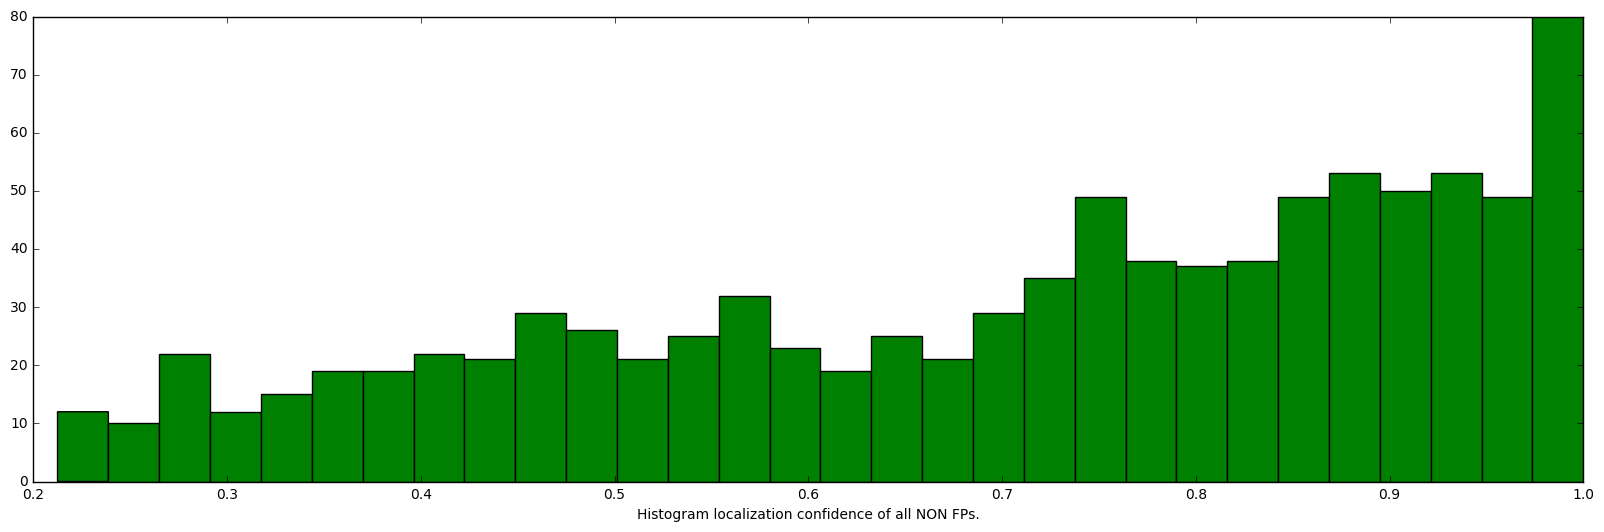

In [45]:
fps_dla_conf = [dla['dla_confidence'] for dla in all_false_positives]
fps_dla_ids = [dla['id'] for dla in all_false_positives]
all_nonfps_dlas = [psub for p in predictions if p['id'] not in fps_dla_ids for psub in p['dlas']]
all_nonfps_conf = [d['dla_confidence'] for d in all_nonfps_dlas]

plt.figure(figsize=(20, 6))
plt.hist(fps_dla_conf, 30, facecolor='green');
plt.xlabel("Histogram localization confidence of FPs.")
plt.ylim([0,80])

plt.figure(figsize=(20, 6))
plt.hist(all_nonfps_conf, 30, facecolor='green');
plt.xlabel("Histogram localization confidence of all NON FPs.")
plt.ylim([0,80])


# Display False Positives list

In [46]:
print json.dumps(all_false_positives, indent=1)

[
 {
  "std_column_density": 0.04339561238884926, 
  "column_density": 20.407451629638672, 
  "spectrum": 3802.769482436101, 
  "rest": 966.3305153949553, 
  "dla_confidence": 1.0, 
  "z_qso": 2.935267925262451, 
  "id": "test_96629_10000_ix_0035", 
  "z_dla": 2.1281264507934727
 }, 
 {
  "std_column_density": 0.013592698611319065, 
  "column_density": 20.380916595458984, 
  "spectrum": 5064.073495238514, 
  "rest": 934.9221993891776, 
  "dla_confidence": 0.5875, 
  "z_qso": 4.416572093963623, 
  "id": "test_96629_10000_ix_0052", 
  "z_dla": 3.1656646090127367
 }, 
 {
  "std_column_density": 0.01780795305967331, 
  "column_density": 20.426456451416016, 
  "spectrum": 4886.523593428336, 
  "rest": 1159.903426145921, 
  "dla_confidence": 1.0, 
  "z_qso": 3.2128710746765137, 
  "id": "test_96629_10000_ix_0097", 
  "z_dla": 3.019613541033616
 }, 
 {
  "std_column_density": 0.046130552887916565, 
  "column_density": 20.628671646118164, 
  "spectrum": 4166.774522219093, 
  "rest": 914.367916

# Display False Negatives list

In [47]:
print json.dumps(sorted(all_false_negatives, key=itemgetter('id')), indent=1)

[
 {
  "zabs": 2.2128586828883607, 
  "NHI": 20.439101814169682, 
  "id": 313, 
  "sl": 938
 }, 
 {
  "zabs": 2.5778553348029067, 
  "NHI": 20.388662442669695, 
  "id": 331, 
  "sl": 3519
 }, 
 {
  "zabs": 2.308110882688297, 
  "NHI": 20.57981038125994, 
  "id": 351, 
  "sl": 1852
 }, 
 {
  "zabs": 2.2803129682616876, 
  "NHI": 21.01519250297041, 
  "id": 539, 
  "sl": 3282
 }, 
 {
  "zabs": 3.5473883817555114, 
  "NHI": 21.899946777889745, 
  "id": 580, 
  "sl": 2508
 }, 
 {
  "zabs": 3.212517840225625, 
  "NHI": 20.340515322714623, 
  "id": 597, 
  "sl": 2355
 }, 
 {
  "zabs": 4.0863543547957315, 
  "NHI": 20.541437746392727, 
  "id": 609, 
  "sl": 16
 }, 
 {
  "zabs": 2.184859203186145, 
  "NHI": 20.37698401393159, 
  "id": 732, 
  "sl": 1025
 }, 
 {
  "zabs": 2.134421856221176, 
  "NHI": 22.01351296999247, 
  "id": 734, 
  "sl": 207
 }, 
 {
  "zabs": 3.583533112738607, 
  "NHI": 20.31744412447081, 
  "id": 805, 
  "sl": 393
 }, 
 {
  "zabs": 2.8157435780932745, 
  "NHI": 20.4563678